# Titanic 
The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.   

**The Challenge**

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

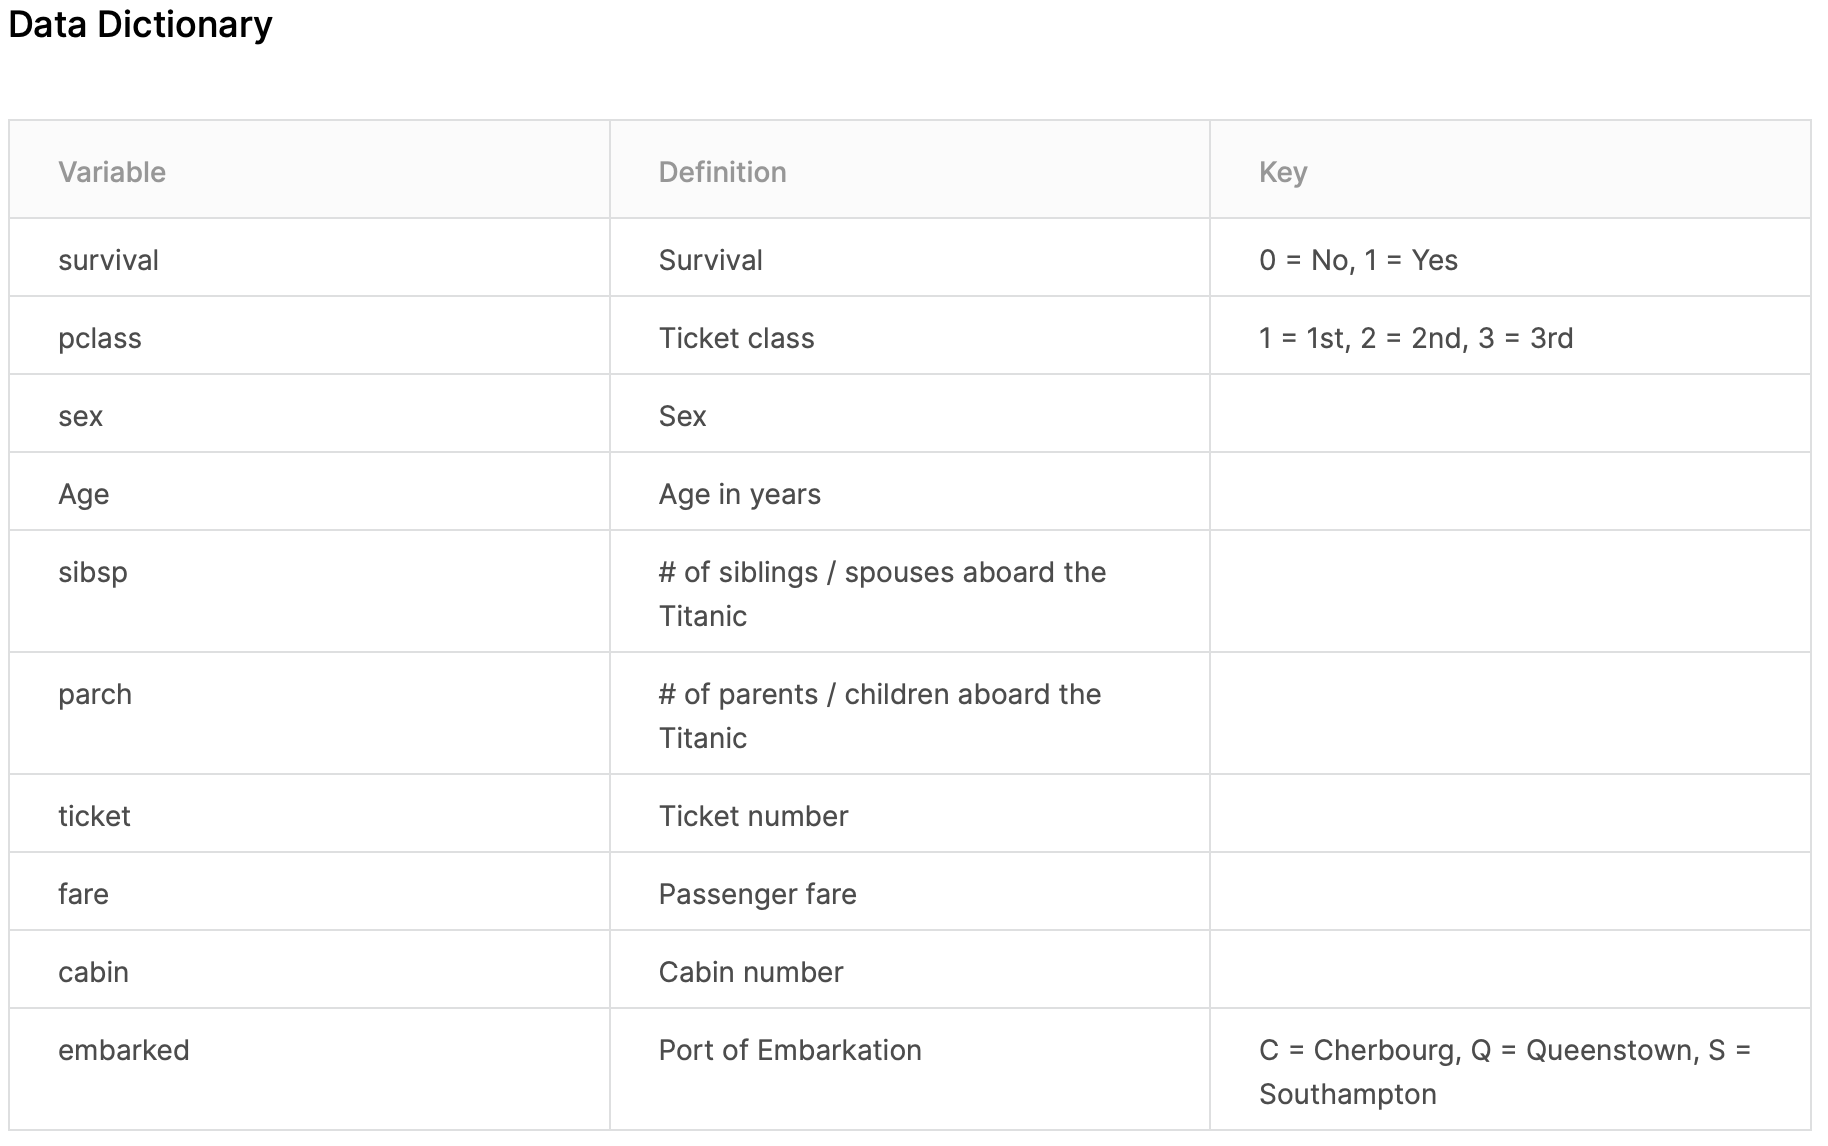

Variable Notes

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

### Summary
Data Exploration
- [Missing Values](#missing)
- [Embarked, Sex, and Pclass VS Survival](#"vs_survival)
- [Age and Sex VS Survival](#age)
- [Sibsp and Parch](#sibsp)

Data Wrangling
- [Remove Unrelated Columns](#1)
- [Convert Categorical Variables](#2)
- [Add travel_alone column](#3)
- [Replace Missing Values and Convert Categorical Variables](#4)

Model Exploration
- [Logistic Regression](#logistic)

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [2]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
len(train_df)

891

### <a id="missing">Missing Value</a>

In [5]:
#count NAs in each category
na_count = train_df.isnull().sum().sort_values(ascending=False)
#calculate %
percent = na_count.div(na_count.sum(), axis=0)
missing_value = pd.concat([na_count,percent],axis = 1, keys = ['count','%'])
missing_value

,count,%
Cabin,687,0.793303
Age,177,0.204388
Embarked,2,0.002309
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


### <a id = "vs_survival">Embarked, Sex, and Pclass  VS Survival</a>

In [6]:
train_df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
train_df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

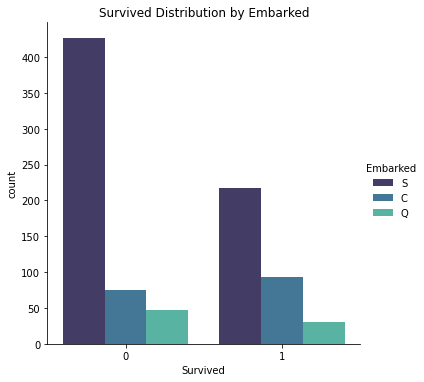

In [8]:
ax1 = sns.catplot(x = "Survived", data=train_df, hue = "Embarked", kind = 'count',palette = 'mako')
plt.title("Survived Distribution by Embarked");

In [9]:
train_df.groupby("Embarked").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


In [10]:
train_df.groupby("Sex").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


Embarked seems to correlated to gender. Southampton and Female tends to have higher survival rate.

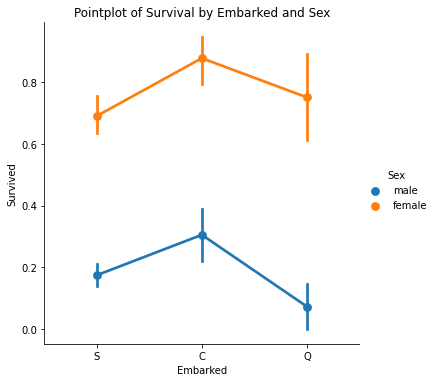

In [11]:
sns.catplot(x= "Embarked", y = "Survived", data=train_df, hue = "Sex", kind = 'point');
plt.title("Pointplot of Survival by Embarked and Sex");

Pclass = 1 is more likely to survive.

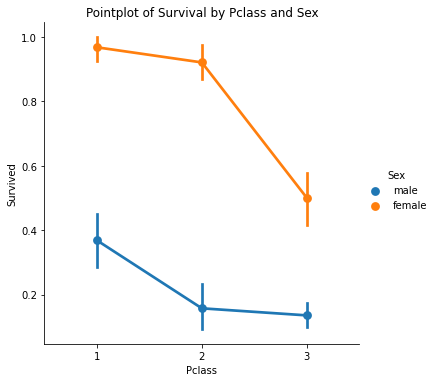

In [12]:
sns.catplot(x= "Pclass", y = "Survived", data=train_df, hue = "Sex", kind = 'point');
plt.title("Pointplot of Survival by Pclass and Sex");

### <a id="age">Age and Sex VS Survival</a>

**Female are more likely to survive**

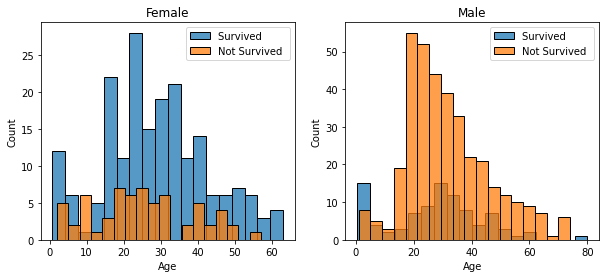

In [13]:
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
#female plot
ax = sns.histplot(train_df[(train_df.Sex == "female")&(train_df.Survived == 1)].Age.dropna(), 
                  bins=18, label = "Survived ", ax = axes[0],kde =False, color = '#1f77b4')
ax = sns.histplot(train_df[(train_df.Sex == "female")&(train_df.Survived == 0)].Age.dropna(), 
                  bins=18, label = "Not Survived ", ax = axes[0],kde =False, color = '#ff7f0e')
ax.legend()
ax.set_title('Female');
#male plot
ax1 = sns.histplot(train_df[(train_df.Sex == "male")&(train_df.Survived == 1)].Age.dropna(), 
                  bins=18, label = "Survived ", ax = axes[1],kde =False, color = '#1f77b4')
ax1 = sns.histplot(train_df[(train_df.Sex == "male")&(train_df.Survived == 0)].Age.dropna(), 
                  bins=18, label = "Not Survived ", ax = axes[1],kde =False, color = '#ff7f0e')
ax1.legend()
ax1.set_title('Male');

### <a id = "sibsp">Sibsp and Parch</a>

In [14]:
data = [train_df,test_df]

In [15]:
print(len(data),len(train_df),len(test_df))

2 891 418


In [16]:
train_df['relatives']=train_df['SibSp']+train_df['Parch']

In [17]:
train_df['travel_alone'] = np.where(train_df['relatives']>0, "No","Yes")

In [18]:
train_df['travel_alone'].value_counts()

Yes    537
No     354
Name: travel_alone, dtype: int64

In [19]:
train_df['relatives'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: relatives, dtype: int64

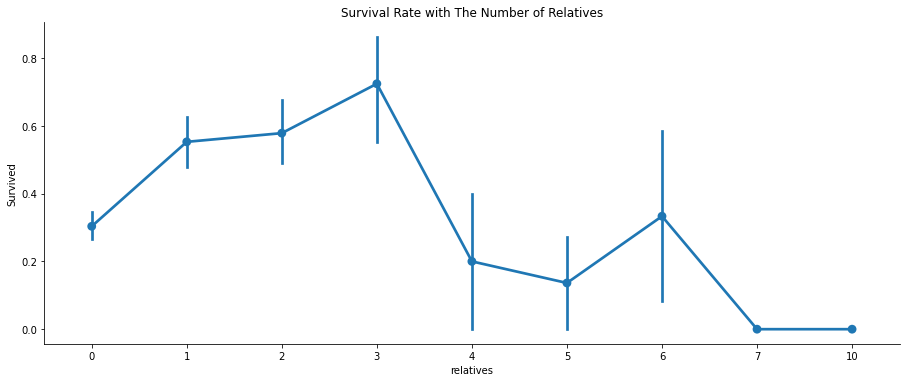

In [20]:
sns.catplot(x= "relatives", y = "Survived", data=train_df, kind = 'point',aspect = 2.5)
plt.title("Survival Rate with The Number of Relatives");

In [76]:
corr = train_df.corr()
corr[['Survived']]

,Survived
Survived,1.000000
Pclass,-0.338481
Sex,0.543351
Age,-0.047266
Embarked,0.106811
travel_alone,0.203367


### Data Wrangling

#### <a id="1">Remove Unrelated Columns</a>

In [22]:
train_df = train_df.drop(['Name', 'PassengerId','Ticket', 'Cabin','Fare'], axis=1)
test_df = test_df.drop(['Name','Ticket', 'Cabin','Fare'], axis=1)

#### <a id = "2">Convert Categorical Variables</a>

In [23]:
train_df['Sex'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
test_df['Sex'] = test_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

#### <a id="3">Add travel_alone column</a>

In [24]:
train_df['relatives']=train_df['SibSp']+train_df['Parch']
train_df['travel_alone'] = np.where(train_df['relatives']>0, 1,0)
test_df['relatives']=test_df['SibSp']+test_df['Parch']
test_df['travel_alone'] = np.where(test_df['relatives']>0, 1, 0)

In [25]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,relatives,travel_alone
0,0,3,0,22.0,1,0,S,1,1
1,1,1,1,38.0,1,0,C,1,1
2,1,3,1,26.0,0,0,S,0,0
3,1,1,1,35.0,1,0,S,1,1
4,0,3,0,35.0,0,0,S,0,0


In [26]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,relatives,travel_alone
0,892,3,0,34.5,0,0,Q,0,0
1,893,3,1,47.0,1,0,S,1,1
2,894,2,0,62.0,0,0,Q,0,0
3,895,3,0,27.0,0,0,S,0,0
4,896,3,1,22.0,1,1,S,2,1


In [27]:
train_df = train_df.drop(['Parch', 'SibSp', 'relatives'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'relatives'], axis=1)

#### <a id="4">Replace Missing Values and Convert Categorical Variables</a>

Replace two missing values in Embarked column with the most common value

In [28]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df.Embarked.mode()[0])

In [29]:
train_df['Embarked'] = train_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test_df['Embarked'] = test_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [30]:
train_df['Pclass'].unique()

array([3, 1, 2])

In [31]:
#replace missing age values based on Pclass median
p1_med = train_df['Age'][train_df['Pclass']==1].median()
p2_med = train_df['Age'][train_df['Pclass']==2].median()
p3_med = train_df['Age'][train_df['Pclass']==3].median()
print(p1_med,p2_med,p3_med)

37.0 29.0 24.0


In [35]:
train_df.loc[(train_df.Age.isnull()) & (train_df.Pclass == 1)]['Age'] = p1_med
train_df.loc[(train_df.Age.isnull()) & (train_df.Pclass == 2)]['Age'] = p2_med
train_df.loc[(train_df.Age.isnull()) & (train_df.Pclass == 3)]['Age'] = p3_med

test_df.loc[(test_df.Age.isnull()) & (test_df.Pclass == 1)]['Age'] = p1_med
test_df.loc[(test_df.Age.isnull()) & (test_df.Pclass == 2)]['Age'] = p2_med
test_df.loc[(test_df.Age.isnull()) & (test_df.Pclass == 3)]['Age'] = p3_med

In [37]:
train_df['Age'] = train_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)

In [38]:
train_df.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age             0
Embarked        0
travel_alone    0
dtype: int64

In [39]:
test_df.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age             0
Embarked        0
travel_alone    0
dtype: int64

### <a id = "logistic">Logistic Regression</a>

In [43]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
print(X_train.shape, Y_train.shape, X_test.shape)

(891, 5) (891,) (418, 5)


In [44]:
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [50]:
# Logistic Regression
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 100)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

In [51]:
print("The confidence score from Logistic model is {:.2f}".format(logreg.score(X_train, Y_train)*100))

The confidence score from Logistic model is 80.25


In [74]:
coeff_df = pd.DataFrame(train_df.columns.delete(0),columns = ['Feature'])
coeff_df["Correlation"] = logreg.coef_[0]
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.492419
3,Embarked,0.288011
2,Age,-0.035973
4,travel_alone,-0.042979
0,Pclass,-1.230034


In [75]:
prediction = pd.DataFrame({"PassengerId": test_df.PassengerId,"Survived": Y_pred})
prediction.to_csv('prediction.csv',index = False)            

Logistic Model has a public score of 0.75358 on Kaggle